Issues with TimeSeriesSplit:  

https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data/105116#105116  

"I dont think even time series split cv is appropriate for time series prediction because it trains on those 4 blocks which capture very unique stretches of the variable's movement, in other words 4 market regimes, which are unlikely to re-appear out-of-sample. I think more randomization is needed while still retaining the order of time events. Cant bootstrap resampling with replacement be used within stacking?"

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
# Machine learning packages
# import xgboost as xgb

# Custom function for neg_mean_absolute_percentage_error
def neg_mean_absolute_percentage_error(y_true, y_pred):
    return -100 * np.mean(np.abs((y_true - y_pred) / y_true))

from Functions import *

# BlockingTimeSeriesSplit (from https://goldinlocks.github.io/Time-Series-Cross-Validation/
# adapted to add a spatial split
class BlockingTimeSeries_withSpatial_Split():
    # Initialise class attributes
    def __init__(self, n_temporal_splits, n_spatial_clusters, temporal_testing_fraction, datetimes, plot_or_not):
        self.n_temporal_splits = n_temporal_splits
        self.n_spatial_clusters = n_spatial_clusters
        self.datetimes = datetimes
        self.temporal_testing_fraction = temporal_testing_fraction
        self.plot_or_not = plot_or_not
        
    def get_n_splits(self, X, y, groups):
        return self.n_temporal_splits
    
    def get_n_spatial_splits(self, X, y, groups):
        return self.n_spatial_clusters  
    
    # This function plots the location of the clusters defined in the sensor population
    @staticmethod
    def plot_spatially(melbourne_sensors_in_this_timeslice,n_temporal_splits, n_spatial_clusters, temporal_i, ax):
        
        # Plot
        geometry = [Point(xy) for xy in zip(melbourne_sensors_in_this_timeslice.Longitude,
                                            melbourne_sensors_in_this_timeslice.Latitude)]
        gdf = gpd.GeoDataFrame(melbourne_sensors_in_this_timeslice, geometry=geometry)
        gdf = gdf.set_crs('EPSG:4326')
        gdf = gdf.to_crs('epsg:3857')
        colors_ls = ['black'] * n_spatial_clusters
        color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange','brown','indigo','violet','cyan']
        
        # If there's just one temporal split, just make one plot
        if n_temporal_splits == 1:
            my_plot = gdf.plot(column=gdf.Cluster_number, ax = ax, markersize = 50, cmap=colors.ListedColormap(color))
            cx.add_basemap(ax = ax)
            ax.axis('off')
            ax.set_axis_off()
        # Otherwise, make plot with subplots
        else:
            my_plot = gdf.plot(column=gdf.Cluster_number, ax = ax[temporal_i], markersize = 50, cmap=colors.ListedColormap(color))
            cx.add_basemap(ax = ax[temporal_i])
            ax[temporal_i].axis('off')
            ax[temporal_i].set_axis_off()

        return my_plot 
    
    # This function runs the cluster analysis to define (for this timeslice), the best
    # way to split the sensors into spatial groups
    
    @staticmethod    
    def run_cluster_analysis(X, start, stop, melbourne_sensors, n_spatial_clusters, n_temporal_splits, temporal_i, plot_or_not,
                            ax):
            
            ##############################################################
            # Get data for just the timeslice being considered (defined by start:stop)
            # And then get a list of sensors which have data during this timeslice
            ##############################################################
            # Add sensor IDs to the data
            X['sensor_id'] = sensor_ids
            # Get list of sensors which have data in this time block
            list_sensors_this_timeslice = X.iloc[start :stop]['sensor_id'].unique().tolist()
            
            ##############################################################
            # Run K-means clustering using just these sensors (i.e. with data in this timeslice)
            # Based on coordinates of sensors
            ##############################################################            
            # Get dataframe containing coordinates for these sensors
            melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)].copy()
            coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   

            # Initialize KMeans instance
            kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
            # coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

            ##############################################################
            # Join back on to main dataset (X) 
            # So now X includes a column containing the cluster number of each row
            # If the row is from a sensor not present in this timeslice, it will have NA
            # Rows not within this timeslice, but with a sensor ID present in this timeslice
            # will get the cluster number for that sensor in this timeslice, but this will be overridden
            # in the future when that timeslice is considered
            ##############################################################      
            # Join the cluster number back onto the dataset of sensors present in this timeslice
            melbourne_sensors_in_this_timeslice['Cluster_number'] = kmeans.labels_

            # Remove a cluster number column if it was already created in previous iteration
            if 'Cluster_number' in X.columns:
                X = X.drop('Cluster_number', axis=1)
            
            # Join this onto X (so now all rows with that sensor_id will show as being in that cluster)
            # Including rows not within this timeslice, but this shouldn't matter
            X = pd.merge(X, melbourne_sensors_in_this_timeslice[['sensor_id','Cluster_number']], on='sensor_id', how='left')

            ##############################################################
            # Send to plotting function (or don't)
            ##############################################################
            if plot_or_not == True:
                my_plot = BlockingTimeSeries_withSpatial_Split.plot_spatially(melbourne_sensors_in_this_timeslice, n_temporal_splits,
                                                                   n_spatial_clusters, temporal_i, ax)
            else:
                my_plot = None
            return X, my_plot
            
    
    def split(self, X, datetimes, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_temporal_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        # I think the margin is about leaving a space between folds
        margin = 0
                
        ###############################################################
        ###############################################################
        # For each of the temporal folds
        ###############################################################
        ###############################################################
        fig, ax = plt.subplots(ncols = self.n_temporal_splits, figsize=(5,5))
        for temporal_i in range(self.n_temporal_splits):
            print(f"Temporal split number {temporal_i}")

            # Find the start, and end index of the temporal split
            start = temporal_i * k_fold_size
            stop = (start + k_fold_size) -1

            # Find the mid point of this split (where the testing data stops and training starts)
            mid = int(self.temporal_testing_fraction * (stop - start)) + start
            # Get the indices equating to the rows which will be in the training and testing portions for this temporal split
            training_indices = pd.Series (indices[start: mid])
            test_indices =pd.Series(indices[mid + margin: stop])
            # print(start, stop)
            print(f"Start: {self.datetimes[start]}, end: {self.datetimes[stop]}")
            
            ###############################################################
            ###############################################################
            # For the portion of data being used in this timeslice (incl. both testing and training):
                # Assign sensor's to clusters (using only the sensors present in this timeslice, sensors not 
                # in this timeslice will get a NA for cluster_number)
            ###############################################################
            ###############################################################
            X_thistimeslice, my_plot = BlockingTimeSeries_withSpatial_Split.run_cluster_analysis(X=X, start = start , stop =stop,
                             melbourne_sensors= melbourne_sensors, n_spatial_clusters=self.n_spatial_clusters, 
                            n_temporal_splits= self.n_temporal_splits,
                             temporal_i=temporal_i, plot_or_not = self.plot_or_not, ax=ax)
            
            ###############################################################
            ###############################################################
            # Create n_spatial_clusters versions of this temporal fold
            # In each case only using the training rows found within n_spatial_clusters - 1 of the clusters
            # and only keeping testing rows found within the other row
            ###############################################################
            ###############################################################
            # For each of the spatial clusters
            for spatial_i in range(len(list(range(0,self.n_spatial_clusters)))):
                # print(f"Spatial split number {spatial_i}")
                
                # For this spatial iteration, create lists to store the training and testing indices 
                this_cluster_trainingindices = []
                this_cluster_testingindices = []

                # For this spatial iteration, define the clusters which will be used in testing and training
                training_clusters = list(range(0,self.n_spatial_clusters))
                training_clusters.pop(spatial_i)
                testing_clusters = [spatial_i]
                
                # Find the indices of rows which 
                this_cluster_trainingindices = X_thistimeslice.iloc[training_indices][X_thistimeslice.iloc[training_indices]['Cluster_number'].isin(training_clusters)].index.values.tolist()
                this_cluster_testingindices = X_thistimeslice.iloc[test_indices][X_thistimeslice.iloc[test_indices]['Cluster_number'].isin(testing_clusters)].index.values.tolist()
                
                #print(f"Clusters {training_clusters} being used here in training. "
                #      f"There are {len(this_cluster_trainingindices)} rows of training data in this cluster")
                      
                # print(f"Clusters {testing_clusters} being used here in testing. "
                #     f"There are {len(this_cluster_testingindices)} rows of testing data in this cluster")
                
                print(f"Testing data is {round((len(this_cluster_testingindices)/len(this_cluster_trainingindices))*100,1)}"
                      f"% of training data")
                
                yield np.array(this_cluster_trainingindices), np.array(this_cluster_testingindices)
        #my_plot.show()        
        #return plot

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [2]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

#### Drop one version of the time variables (either cyclical or dummy versions)

In [3]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Delete the year variable

In [4]:
# del Xfull['year']

#### Get the sensor locations (this is needed if splitting the data spatially in cross validation)

In [5]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

#### Get as series the sensor ids and datetimes

In [6]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [7]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [8]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

In [9]:
models_dict = {"rf_regressor":rf_model_pipeline}

### Print spatial locations of sensor (need footfall_spatial environment)

#### Create the BlockedTimeSeriesSplit object

In [10]:
n_temporal_blocks=4
n_spatial_clusters = 5
btss = BlockingTimeSeries_withSpatial_Split(n_temporal_splits=n_temporal_blocks, n_spatial_clusters = n_spatial_clusters,
                                           temporal_testing_fraction = 0.9, datetimes = datetimes, plot_or_not =True)

#### Plot the fold indices

Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00
Testing data is 2.0% of training data


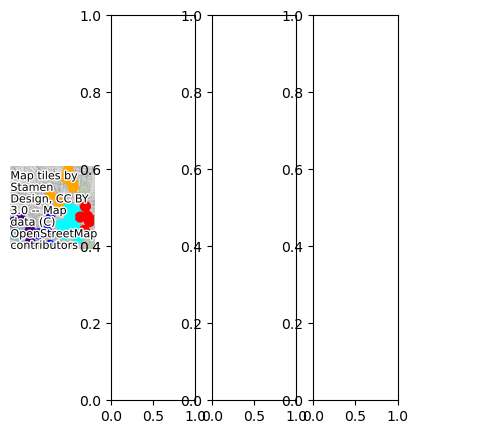

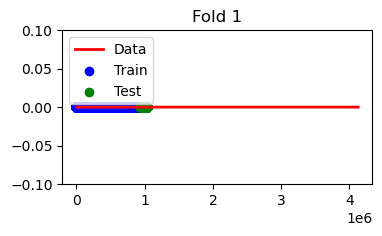

Testing data is 1.6% of training data


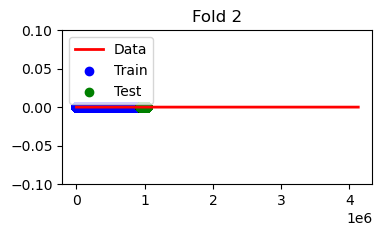

Testing data is 2.2% of training data


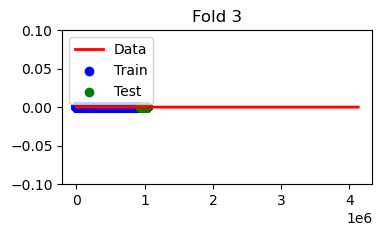

Testing data is 1.4% of training data


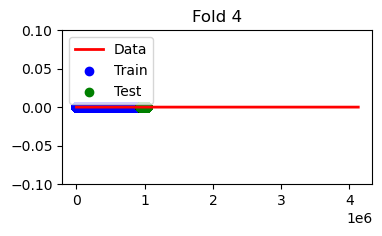

Testing data is 8.9% of training data


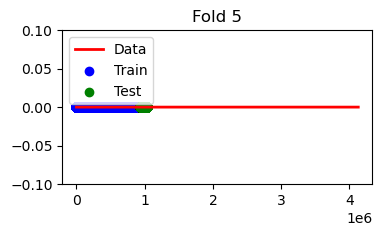

Temporal split number 1
Start: 2015-12-25 23:00:00, end: 2018-11-17 10:00:00
Testing data is 2.5% of training data


<Figure size 640x480 with 0 Axes>

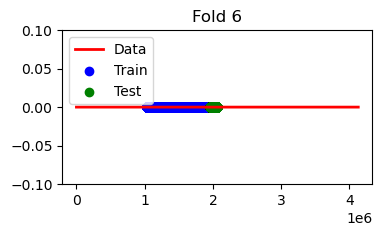

Testing data is 3.0% of training data


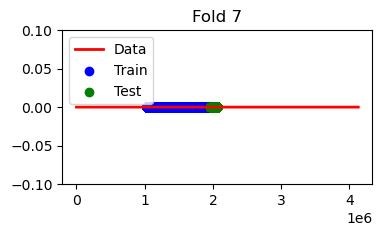

Testing data is 2.5% of training data


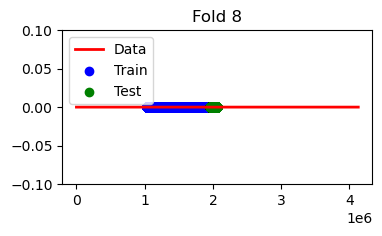

Testing data is 2.1% of training data


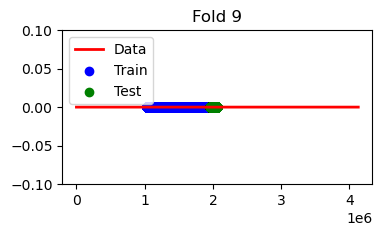

Testing data is 4.0% of training data


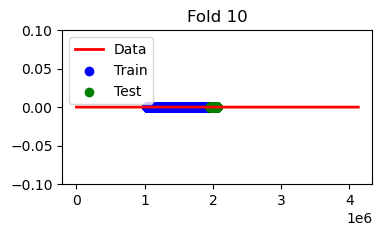

Temporal split number 2
Start: 2018-11-17 10:00:00, end: 2021-01-25 04:00:00
Testing data is 2.2% of training data


<Figure size 640x480 with 0 Axes>

In [ ]:
for fold, (train_index, test_index) in enumerate(btss.split(Xfull, datetimes)):
    pass
    plt.figure(figsize=(4, 2))
    plt.plot(np.arange(len(Yfull)), np.zeros_like(Yfull), 'r-', lw=2, label='Data')
    plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
    plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
    plt.title(f'Fold {fold+1}')
    plt.legend(loc='upper left')
    plt.ylim(-0.1, 0.1)
    plt.show()

### Cross validation manually 

In [ ]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

# Loop through each of the cross validation splits
for number, (train_index, test_index) in enumerate(btss.split(Xfull, datetimes)):
    print(number)
    # Get train and testing data for this fold
    print(f"train index: {len(train_index)}")
    print(f"test index: {len(test_index)}")
    X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
    y_train, y_test = Yfull[train_index], Yfull[test_index]
    # Fit the model on the training data
    rf_model_pipeline.fit(X_train, y_train)
    # Use it to make predictions on the testing data, and store these
    y_pred = rf_model_pipeline.predict(X_test)
    predicted_values.append(y_pred)
    # Store the datetimes
    datetimes_used.append(datetimes[train_index])
    # Store the actual values for the testing data
    observed_values.append(Yfull[y_test])
    # Calculate the error metrics for this fold and append to the scores lists
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
        
neg_mae_scores = [-score for score in mae_scores]    

Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2022-10-31 23:00:00
Testing data is 2.8% of training data
0
train index: 3103328
test index: 85845
Testing data is 2.5% of training data
1
train index: 2966989
test index: 75500


In [24]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

In [2]:
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

mean_mae, mean_r2, mean_rmse

NameError: name 'np' is not defined

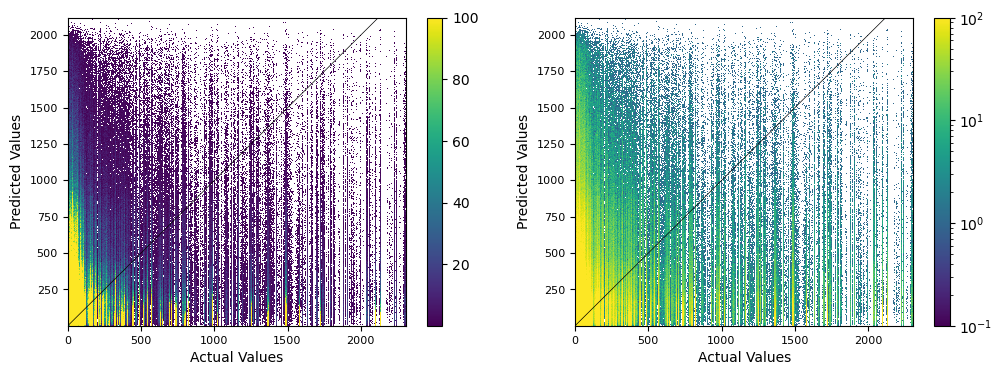

In [26]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values_all, predicted_values_all, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], observed_values_all, predicted_values_all, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

### Run model with cross validation

rf_regressor
Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2022-10-31 23:00:00
Testing data is 10.8% of training data
Testing data is 9.4% of training data
Testing data is 42.1% of training data
Testing data is 0.8% of training data
Testing data is 6.2% of training data
Ran in 58 minutes


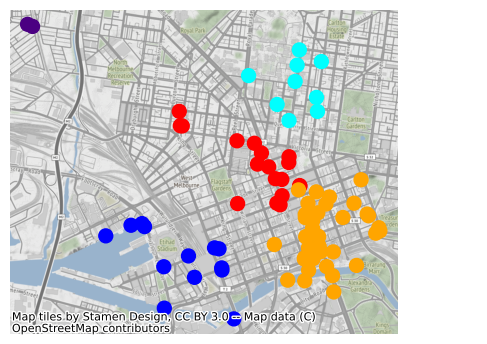

In [27]:
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=btss, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    # error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
# error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

### Print table showing error metrics associated with each model

In [74]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,308.28,6.565443e+15,1.23,469.12


In [ ]:
# #### Run cross_val_predict to get predictions
# start = time()
# predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=btss)
# end = time()
# print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))
# # Convert to a dataframe
# predictions_df=pd.DataFrame(predictions)
# # Store the predictions
# # predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   